## Function

In [1]:
def top_news(ticker, n = 5, save = False):
    
    import requests
    import pandas as pd
    import matplotlib.pyplot as plt

    fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

    stock_news = requests.get(f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}\
    &limit=100&apikey={fm_key}').json()
    stock_news = pd.DataFrame(stock_news)
    stock_news = stock_news[stock_news['site'].isin(['24/7 Wall Street', 'CNBC', 'Forbes', 'Barrons',\
                                                     'Market Watch'])]
    
    if len(stock_news) == 0:
        return None

    text_str = ' '.join(str(x) for x in stock_news['text'])
    
    import re
    from pprint import pprint

    import numpy as np
    from nltk import sent_tokenize, word_tokenize

    from nltk.cluster.util import cosine_distance

    MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)

    def normalize_whitespace(text):
        """
        Translates multiple whitespace into single space character.
        If there is at least one new line character chunk is replaced
        by single LF (Unix new line) character.
        """
        return MULTIPLE_WHITESPACE_PATTERN.sub(_replace_whitespace, text)


    def _replace_whitespace(match):
        text = match.group()

        if "\n" in text or "\r" in text:
            return "\n"
        else:
            return " "


    def is_blank(string):
        """
        Returns `True` if string contains only white-space characters
        or is empty. Otherwise `False` is returned.
        """
        return not string or string.isspace()


    def get_symmetric_matrix(matrix):
        """
        Get Symmetric matrix
        :param matrix:
        :return: matrix
        """
        return matrix + matrix.T - np.diag(matrix.diagonal())


    def core_cosine_similarity(vector1, vector2):
        """
        measure cosine similarity between two vectors
        :param vector1:
        :param vector2:
        :return: 0 < cosine similarity value < 1
        """
        return 1 - cosine_distance(vector1, vector2)

    class TextRank4Sentences():

        def __init__(self):
            self.damping = 0.85  # damping coefficient, usually is .85
            self.min_diff = 1e-5  # convergence threshold
            self.steps = 100  # iteration steps
            self.text_str = None
            self.sentences = None
            self.pr_vector = None

        def _sentence_similarity(self, sent1, sent2, stopwords=None):
            if stopwords is None:
                stopwords = []

            sent1 = [w.lower() for w in sent1]
            sent2 = [w.lower() for w in sent2]

            all_words = list(set(sent1 + sent2))

            vector1 = [0] * len(all_words)
            vector2 = [0] * len(all_words)

            # build the vector for the first sentence
            for w in sent1:
                if w in stopwords:
                    continue
                vector1[all_words.index(w)] += 1

            # build the vector for the second sentence
            for w in sent2:
                if w in stopwords:
                    continue
                vector2[all_words.index(w)] += 1

            return core_cosine_similarity(vector1, vector2)

        def _build_similarity_matrix(self, sentences, stopwords=None):
            # create an empty similarity matrix
            sm = np.zeros([len(sentences), len(sentences)])

            for idx1 in range(len(sentences)):
                for idx2 in range(len(sentences)):
                    if idx1 == idx2:
                        continue

                    sm[idx1][idx2] = self._sentence_similarity(sentences[idx1],\
                                                               sentences[idx2], stopwords=stopwords)

            # Get Symmeric matrix
            sm = get_symmetric_matrix(sm)

            # Normalize matrix by column
            norm = np.sum(sm, axis=0)
            sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

            return sm_norm

        def _run_page_rank(self, similarity_matrix):

            pr_vector = np.array([1] * len(similarity_matrix))

            # Iteration
            previous_pr = 0
            for epoch in range(self.steps):
                pr_vector = (1 - self.damping) + self.damping * np.matmul(similarity_matrix, pr_vector)
                if abs(previous_pr - sum(pr_vector)) < self.min_diff:
                    break
                else:
                    previous_pr = sum(pr_vector)

            return pr_vector

        def _get_sentence(self, index):

            try:
                return self.sentences[index]
            except IndexError:
                return ""

        def get_top_sentences(self, number=5):

            top_sentences = {}

            if self.pr_vector is not None:

                sorted_pr = np.argsort(self.pr_vector)
                sorted_pr = list(sorted_pr)
                sorted_pr.reverse()

                index = 0
                for epoch in range(number):
                    #print (str(sorted_pr[index]) + " : " + str(self.pr_vector[sorted_pr[index]]))
                    sent = self.sentences[sorted_pr[index]]
                    sent = normalize_whitespace(sent)
                    top_sentences[sent] = self.pr_vector[sorted_pr[index]]
                    index += 1

            return top_sentences

        def analyze(self, text, stop_words=None):
            self.text_str = text
            self.sentences = sent_tokenize(self.text_str)

            tokenized_sentences = [word_tokenize(sent) for sent in self.sentences]

            similarity_matrix = self._build_similarity_matrix(tokenized_sentences, stop_words)

            self.pr_vector = self._run_page_rank(similarity_matrix)

            #print(self.pr_vector)

    tr4sh = TextRank4Sentences()
    tr4sh.analyze(text_str)
    top_sents = tr4sh.get_top_sentences(min(n, len(tr4sh.sentences)))
    
    from matplotlib.pyplot import imshow
    import numpy as np
    from IPython.display import display

    from PIL import Image, ImageDraw, ImageFont

    # create an image
    #out = Image.new("RGB", (3000, 400), (255, 255, 255))
    #d = ImageDraw.Draw(out)
    #i = 1
    #for key in top_sents:
    #    fnt = ImageFont.truetype("Verdana.ttf", int(13*float(top_sents[key])))
    #    d.text((20, 50*i), str(key), fill = "#000", font = fnt)
    #    i += 1
        
    #plt.figure(figsize = (900, 120))
    #plt.axis('off')
    #_ = imshow(out, interpolation='nearest', aspect='auto')
    
    #out.save(f"{ticker}.jpg", dpi=(12000, 12000))
    
    out = Image.new("RGB", (2500, int(n*120)), (255, 255, 255))
    d = ImageDraw.Draw(out)
    i = 1
    for key in top_sents:
        fnt = ImageFont.truetype("Verdana.ttf", int(24*float(top_sents[key])))
        d.multiline_text((15, 160*i), ('\n').join(str(key).split(', ')), fill = "#000", font = fnt, spacing = 3)
        i += 1
        
    plt.figure(figsize = (900, 50))
    plt.axis('off')
    _ = imshow(out)
    if save:
        out.save(f"{ticker}.jpg", dpi=(12000, 12000))

## For test

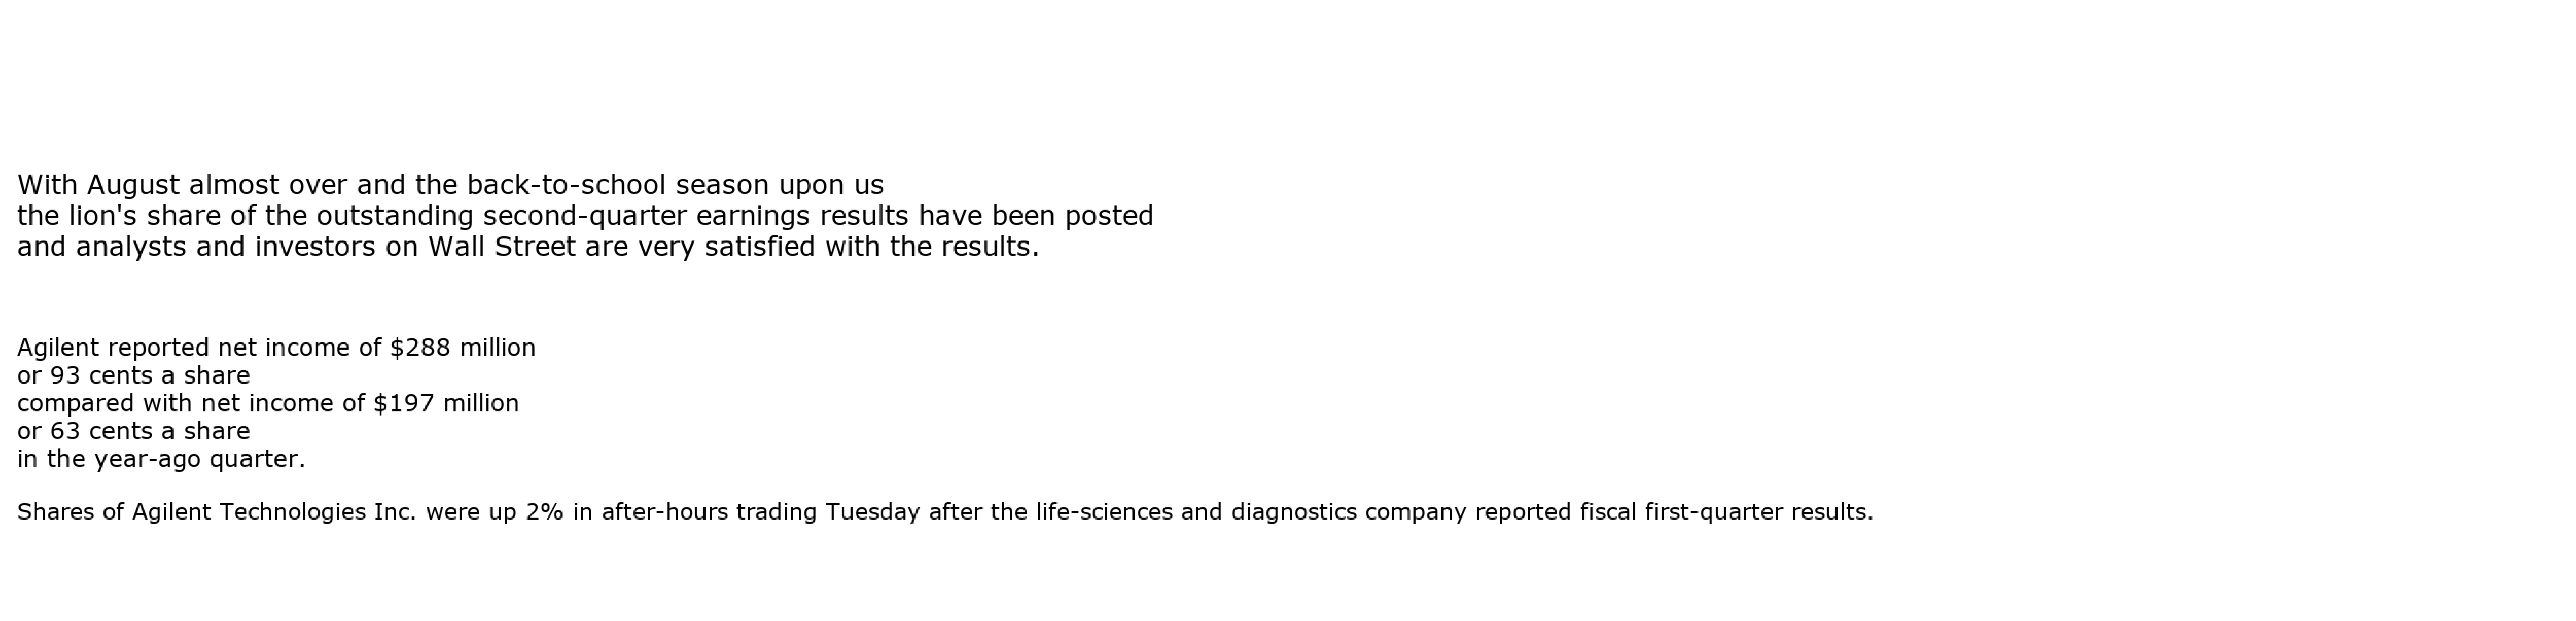

In [2]:
top_news('AAPL', save = False)

In [ ]:
plt.rcParams.update({'figure.max_open_warning': 0})

tickers = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={fm_key}').json()
tickers = pd.DataFrame(tickers)
tickers = tickers.loc[:,'symbol'].to_list()

for ticker in tickers[0:20]:
    top_news(ticker, save = False)